In [58]:
import pandas as pd
import sys, random
sys.path.append("../../Model/")

import modules.constants as const
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

import numpy as np
import modules.utils as utils
import modules.plot_utils as plutils
import modules.plot_constants as pltconst
from modules.plot_constants import uzh_colors

from tqdm import tqdm
from matplotlib.lines import Line2D

pltconst.set_plot_parameters()

metrics_names = ["mse", "rmse", "mae", "mape"]

In [59]:
tezos_predictions_dir = "/mnt/Ivana/Results/Tezos/Predictions/"
tezos_metrics_dir = "/mnt/Ivana/Results/Tezos/Metrics/"
tezos_input_y_dir = "/mnt/Ivana/Data/Tezos/ModelInput/y/"
tezos_latex_dir = "/mnt/Ivana/Results/Tezos/Latex/"

df_y = pd.read_csv(tezos_input_y_dir + "TargetWithDates.csv")
df_y.Date = pd.to_datetime(df_y.Date)

TEZOS_PREDICTION_LEN = 490

y_test_tezos = df_y.Price.values[-TEZOS_PREDICTION_LEN:]
dates_tezos = df_y.Date.values[-TEZOS_PREDICTION_LEN:]

data_names_tezos = ["Market", "Network", "Social", "Supply", "TI"]

file_dict = {
    "Simple Model/Predictions_no_segmentation256.npy": ["Simple_no_segmentation_all", "Simple_no_segmentation_short"],
    "Simple Model/Predictions_with_segmentation256.npy":["Simple_with_segmentation_all", "Simple_with_segmentation_short"],
    "Complex/Predictions_no_segmentation.npy":["Complex_no_segmentation_all", "Complex_no_segmentation_short"],
    "Complex/Predictions_with_segmentation.npy":["Complex_with_segmentation_all", "Complex_with_segmentation_short"]
}

best_colors = [uzh_colors["red"], uzh_colors["green"], uzh_colors["grey"], uzh_colors["blue"], uzh_colors["turquoise"]]

tezos_figures_dir = const.tezos_results_dir + "Figures/"

In [60]:
def extract_top_strategies(predictions_file, metrics_file, top_n = 3, extract_best = True):
    pred_df = pd.DataFrame(np.load(predictions_file, allow_pickle=True))
    pred_df.columns = ["combination_number"] + ["col"+str(i) for i in range(1,6)] + ["predictions"]
    metrics_df = pd.read_csv(metrics_file)

    pred_df = pd.merge(pred_df, metrics_df[["combination_number", "mse"]], on="combination_number", how="left")

    # best_numbers = metrics_df.sort_values(by = "mse", ascending=extract_best).reset_index(drop=True).loc[:(top_n-1), "combination_number"]
    # top_strategies = pred_df[pred_df[pred_df.columns[0]].isin(best_numbers)].reset_index(drop=True)

    top_strategies = pred_df.sort_values(by = "mse", ascending=extract_best).reset_index(drop=True).loc[:(top_n-1), ]
    top_strategies.drop("mse", axis=1, inplace=True)
    return top_strategies

def create_label(x, data_names):
    indexes_included = np.where(x[1:6] == 1)[0]
    label = "+".join(np.array(data_names)[indexes_included])
    return label

def generate_random_color():
    red = random.randint(0, 255)
    green = random.randint(0, 255)
    blue = random.randint(0, 255)
    return f"#{red:02X}{green:02X}{blue:02X}"

def convert_predictions_df_to_plot_data_df(pred_df, data_names, dates, y_test):
    plot_data = pred_df.copy()
    plot_data.columns = ["number"] + data_names + ["y"]

    plot_data["label"] = plot_data.apply(lambda x: create_label(x, data_names), axis = 1)
    plot_data["x"] = [dates for i in range(plot_data.shape[0])]

    plot_data = plot_data[["x", "y", "label"]]

    colors =  best_colors[:plot_data.shape[0]]
    if plot_data.shape[0] > 5:
        colors = colors + [generate_random_color() for i in range(plot_data.shape[0] - 5)]
    plot_data["color"] = colors

    new_row = {
        "x" : dates,
        "y" : y_test,
        "label" : "Real Value",
        "color":"black"
    }

    plot_data = pd.concat([pd.DataFrame([new_row]), plot_data], axis = 0).reset_index(drop=True)
    return plot_data

def plot_data_simple(ax, plot_data):
    min_x, max_x = min(plot_data.loc[0, "x"]), max(plot_data.loc[0, "x"])
    
    for i, row in plot_data.iterrows():
        
        ax.plot(row["x"], row["y"], label = row["label"], color = row["color"])   

        min_x = min(min_x, min(row["x"]))
        max_x = max(max_x, max(row["x"]))

    ax.set_xlabel("Date")
    ax.set_ylabel("Price in USD")
    ax.grid(zorder=100, lw =0.5, color = 'lightgray')

    leg = plt.legend(frameon=True,facecolor='white', framealpha=1, loc="upper right")
    frame = leg.get_frame()
    frame.set_linewidth(0)

    ax.set_xlim(min_x, max_x)

    return ax



### Simple Model No Segmentation

In [61]:
predictions_file = tezos_predictions_dir + "Simple Model/Predictions_no_segmentation.npy"
metrics_file = tezos_metrics_dir + "Simple_no_segmentation_all.csv"

# pred_df = pd.DataFrame(np.load(predictions_file, allow_pickle=True))
# pred_df.columns = ["combination_number"] + ["col"+str(i) for i in range(1,6)] + ["predictions"]
# metrics_df = pd.read_csv(metrics_file)

# pred_df["mse"] = pred_df.predictions.apply(lambda x: mean_squared_error(y_pred=x, y_true=y_test_tezos))

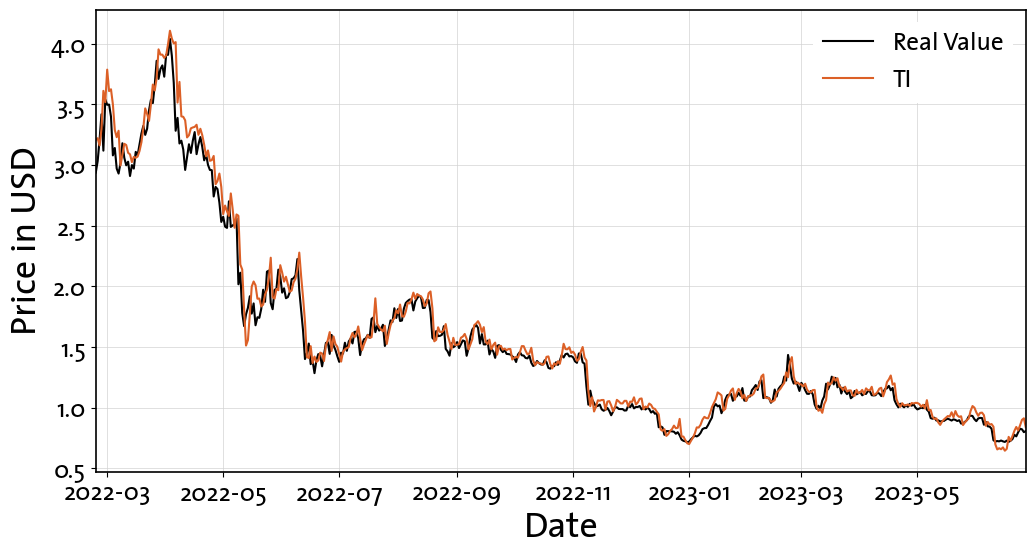

In [62]:
file_name = tezos_figures_dir + "Simple_no_segmentation_best1.png"

df1  = extract_top_strategies(predictions_file, metrics_file, top_n=1)
best_no_segment = df1
plot_data1 = convert_predictions_df_to_plot_data_df(df1, data_names_tezos, dates_tezos, y_test_tezos)

fig, ax = plt.subplots(1,1, figsize=(12, 6))
plot_data_simple(ax, plot_data1)
plt.savefig(file_name, bbox_inches = "tight")

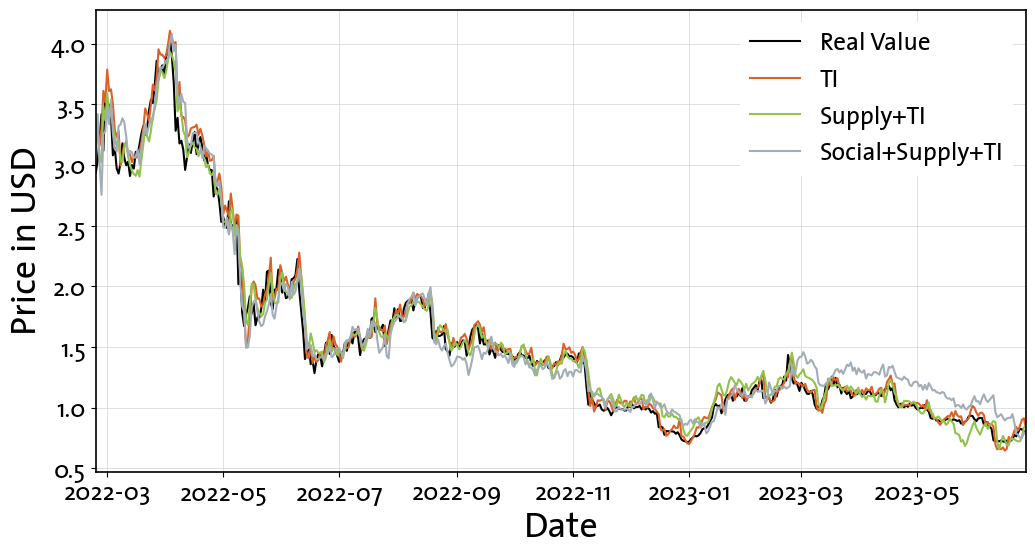

In [63]:
file_name = tezos_figures_dir + "Simple_no_segmentation_best3.png"

df3  = extract_top_strategies(predictions_file, metrics_file, top_n=3)
plot_data3 = convert_predictions_df_to_plot_data_df(df3, data_names_tezos, dates_tezos, y_test_tezos)

fig, ax = plt.subplots(1,1, figsize=(12, 6))
plot_data_simple(ax, plot_data3)
plt.savefig(file_name, bbox_inches = "tight")

### Simple Model With Segmentation

In [64]:
predictions_file = tezos_predictions_dir + "Simple Model/Predictions_with_segmentation.npy"
metrics_file = tezos_metrics_dir + "Simple_with_segmentation_all.csv"


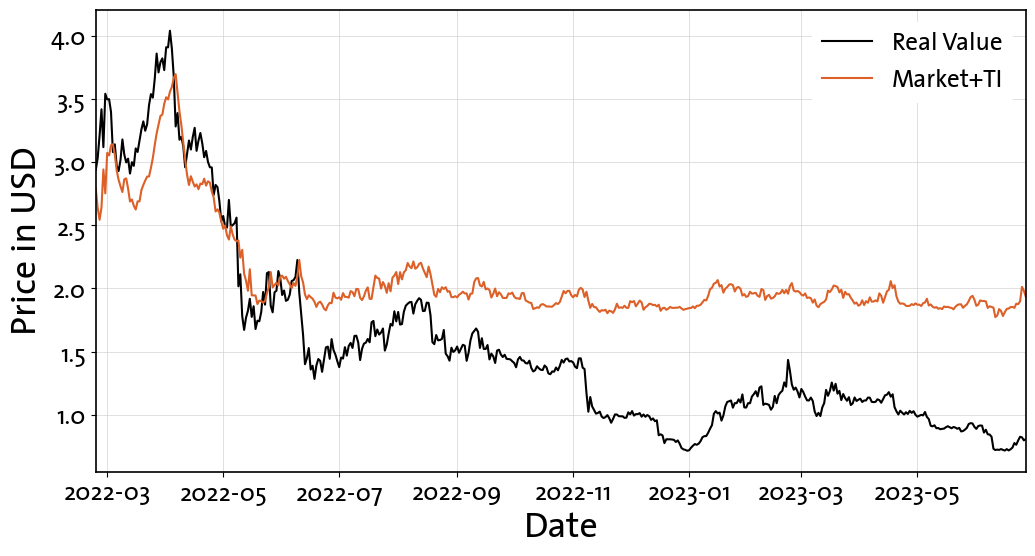

In [65]:
file_name = tezos_figures_dir + "Simple_with_segmentation_best1.png"

df1  = extract_top_strategies(predictions_file, metrics_file, top_n=1)
best_with_segment = df1
plot_data1 = convert_predictions_df_to_plot_data_df(df1, data_names_tezos, dates_tezos, y_test_tezos)

fig, ax = plt.subplots(1,1, figsize=(12, 6))
plot_data_simple(ax, plot_data1)
plt.savefig(file_name, bbox_inches = "tight")

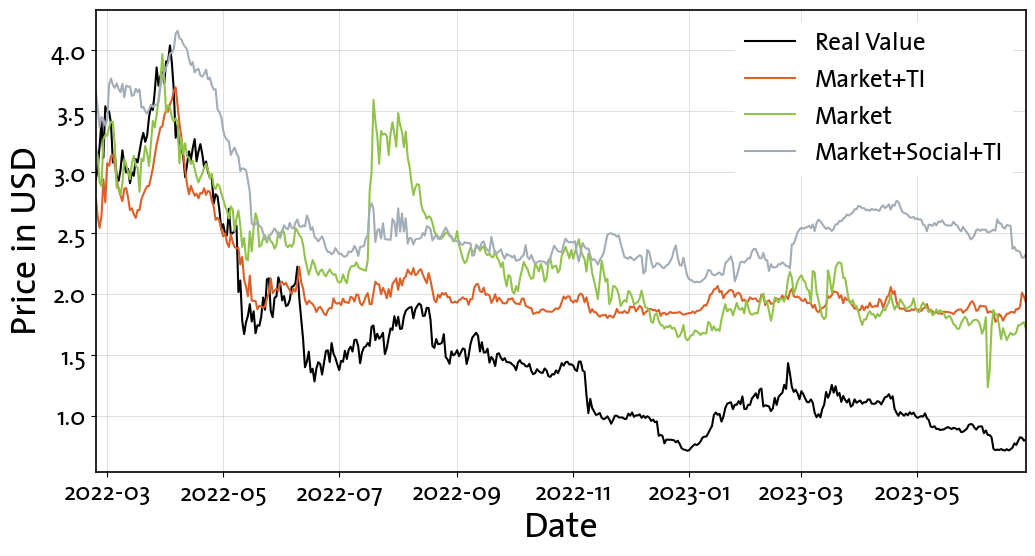

In [66]:
file_name = tezos_figures_dir + "Simple_with_segmentation_best3.png"

df3  = extract_top_strategies(predictions_file, metrics_file, top_n=3)
plot_data3 = convert_predictions_df_to_plot_data_df(df3, data_names_tezos, dates_tezos, y_test_tezos)

fig, ax = plt.subplots(1,1, figsize=(12, 6))
plot_data_simple(ax, plot_data3)
plt.savefig(file_name, bbox_inches = "tight")

### Compare segment vs non segment

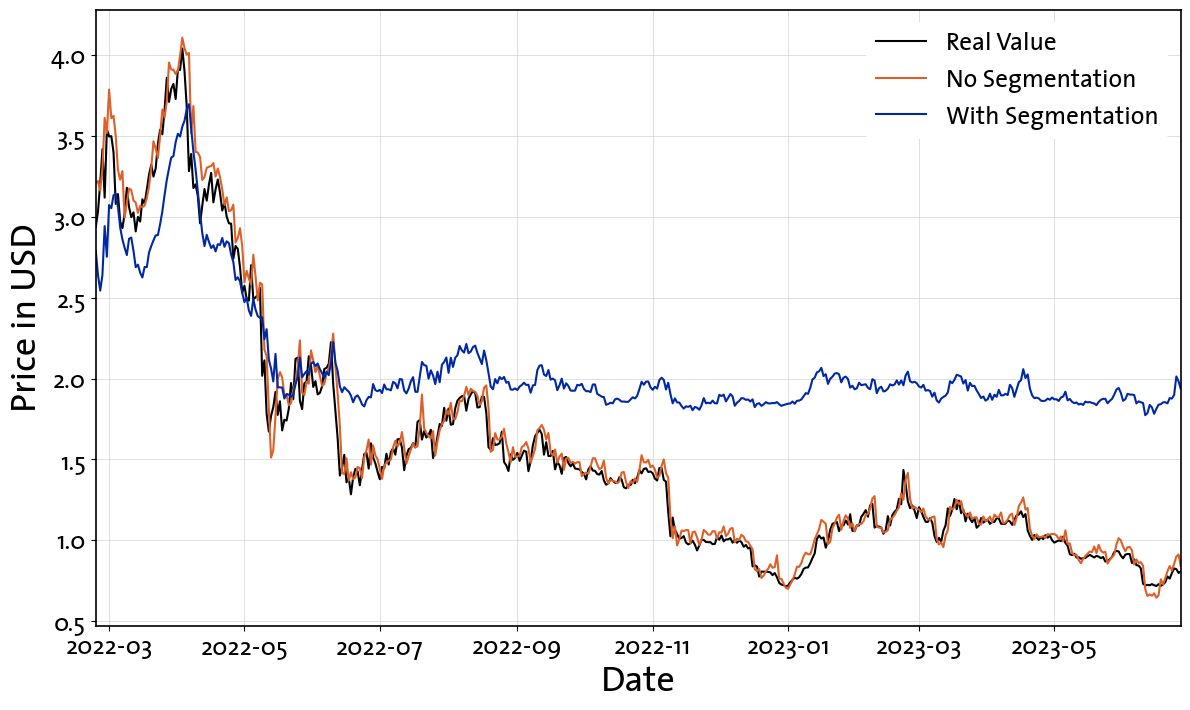

In [67]:
file_name = tezos_figures_dir + "Simple_no_segm_vs_with_segm.png"

plot_data_no_segm = convert_predictions_df_to_plot_data_df(best_no_segment, data_names_tezos, dates_tezos, y_test_tezos)
plot_data_with_segm = convert_predictions_df_to_plot_data_df(best_with_segment, data_names_tezos, dates_tezos, y_test_tezos)

plot_data_no_segm.loc[1, "label"] = "No Segmentation"
plot_data_with_segm.loc[1, "label"] = "With Segmentation"
plot_data_with_segm.loc[1, "color"] = uzh_colors["blue"]

plot_final = pd.concat([plot_data_no_segm, plot_data_with_segm.iloc[[1]]], axis = 0)


fig, ax = plt.subplots(1, 1, figsize = (14, 8))
plot_data_simple(ax, plot_final)
plt.savefig(file_name, bbox_inches = "tight")

### Complex Model No Segmentation

In [68]:
from sklearn.metrics import mean_squared_error

In [69]:
predictions_file = tezos_predictions_dir +  "Complex/Predictions_complex_no_segmentation.npy"
metrics_file = tezos_metrics_dir + "Complex_no_segmentation_all.csv"

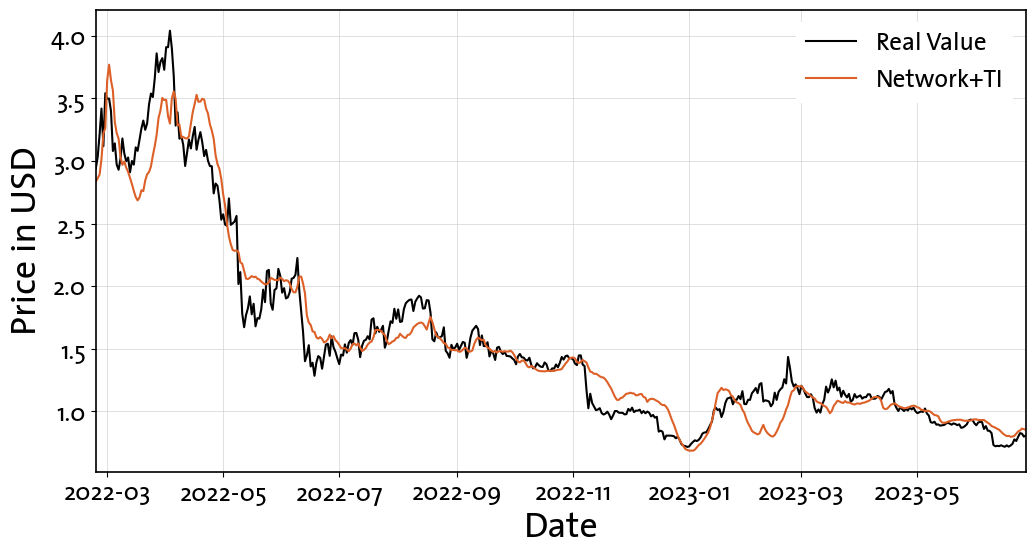

In [70]:
file_name = tezos_figures_dir + "Complex_no_segmentation_best1.png"

df1  = extract_top_strategies(predictions_file, metrics_file, top_n=1)
complex_df_no_segment = df1
plot_data1 = convert_predictions_df_to_plot_data_df(df1, data_names_tezos, dates_tezos, y_test_tezos)

plot_data1["mse"] = plot_data1.y.apply(lambda x: mean_squared_error(y_true=y_test_tezos, y_pred=x))
fig, ax = plt.subplots(1,1, figsize=(12, 6))
plot_data_simple(ax, plot_data1)
plt.savefig(file_name, bbox_inches = "tight")

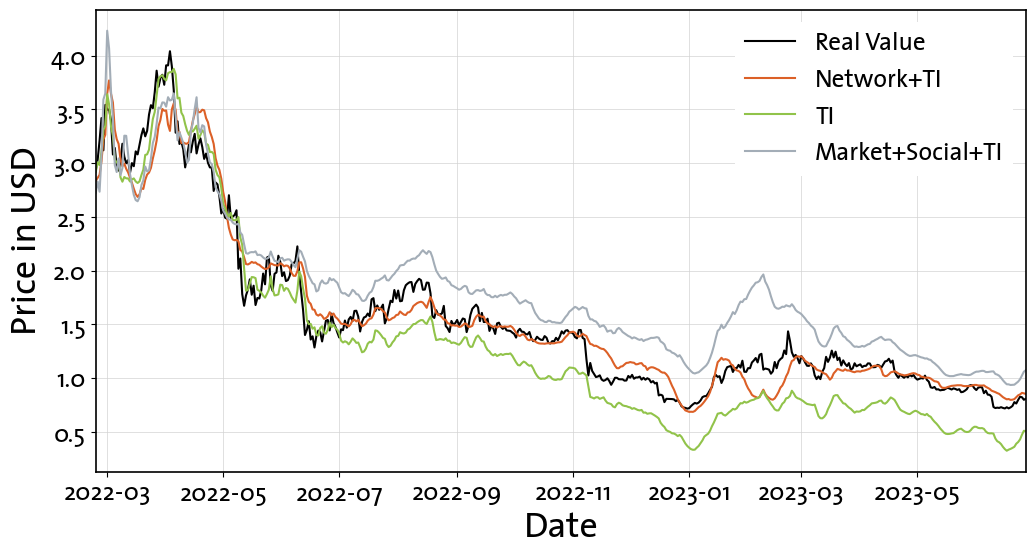

In [71]:
file_name = tezos_figures_dir + "Complex_no_segmentation_best3.png"

df3  = extract_top_strategies(predictions_file, metrics_file, top_n=3)
plot_data3 = convert_predictions_df_to_plot_data_df(df3, data_names_tezos, dates_tezos, y_test_tezos)

fig, ax = plt.subplots(1,1, figsize=(12, 6))
plot_data_simple(ax, plot_data3)
plt.savefig(file_name, bbox_inches = "tight")

### Complex Model With Segmentation

In [72]:
predictions_file = tezos_predictions_dir +  "Complex/Predictions_complex_with_segmentation.npy"
metrics_file = tezos_metrics_dir + "Complex_with_segmentation_all.csv"

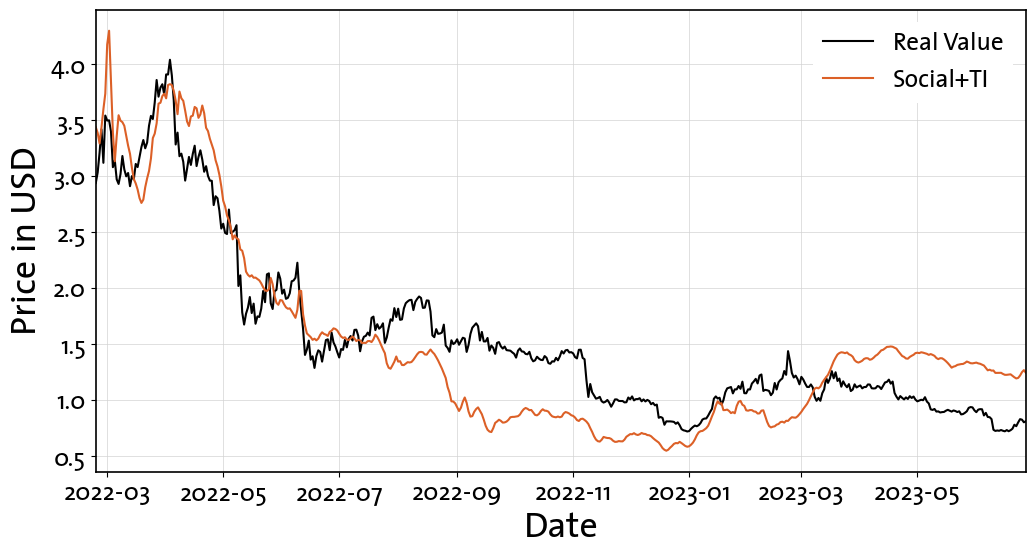

In [73]:
file_name = tezos_figures_dir + "Complex_with_segmentation_best1.png"

df1  = extract_top_strategies(predictions_file, metrics_file, top_n=1)
best_complex_with_segment = df1

plot_data1 = convert_predictions_df_to_plot_data_df(df1, data_names_tezos, dates_tezos, y_test_tezos)

fig, ax = plt.subplots(1,1, figsize=(12, 6))
plot_data_simple(ax, plot_data1)
plt.savefig(file_name, bbox_inches = "tight")

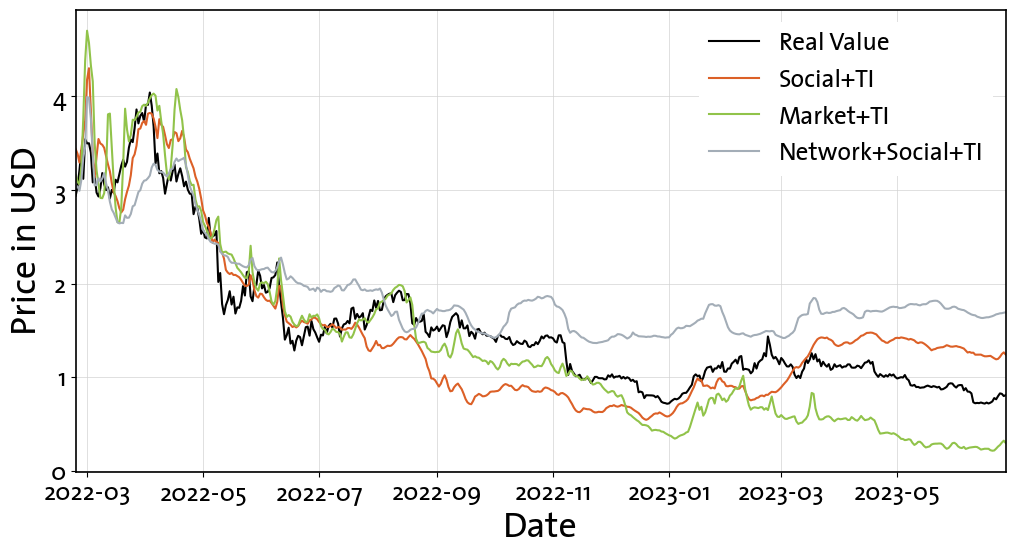

In [74]:
file_name = tezos_figures_dir + "Complex_with_segmentation_best3.png"

df3  = extract_top_strategies(predictions_file, metrics_file, top_n=3)
plot_data3 = convert_predictions_df_to_plot_data_df(df3, data_names_tezos, dates_tezos, y_test_tezos)

fig, ax = plt.subplots(1,1, figsize=(12, 6))
plot_data_simple(ax, plot_data3)
plt.savefig(file_name, bbox_inches = "tight")

### Compare simple with segmentation and complex with segmentation

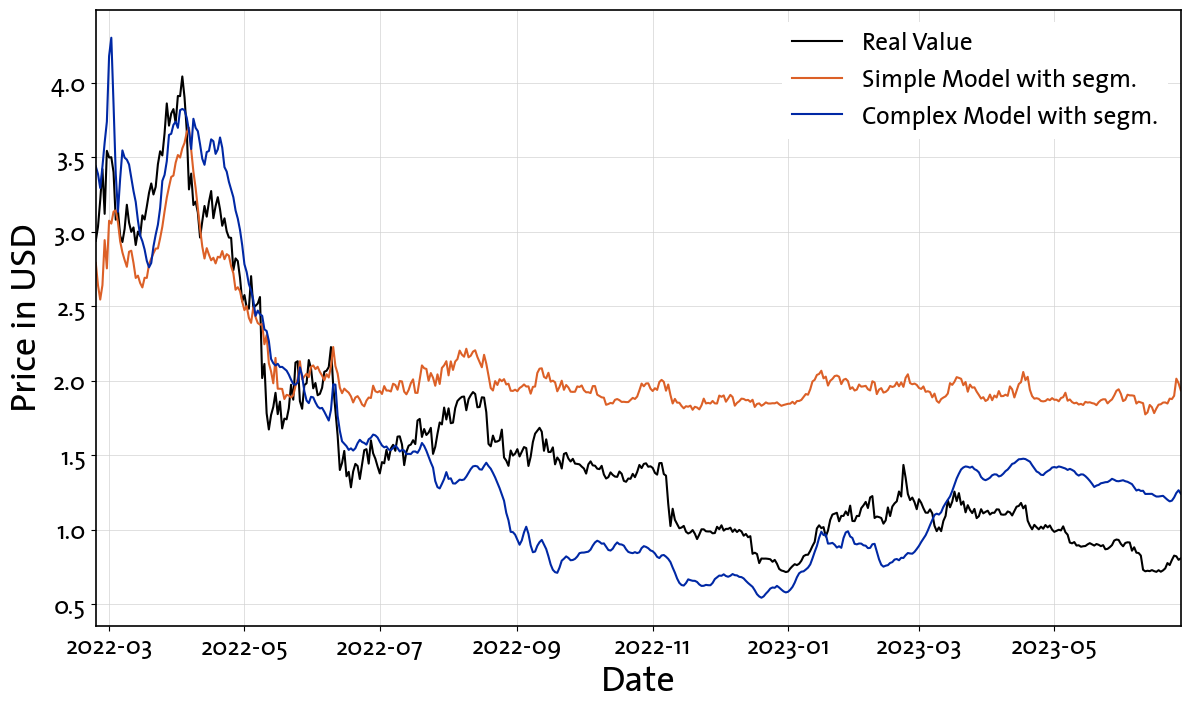

In [75]:
file_name = tezos_figures_dir + "Simple_vs_complex_with_segmentation.png"

plot_df_simple = convert_predictions_df_to_plot_data_df(best_with_segment, data_names_tezos, dates_tezos, y_test_tezos)
plot_data_complex = convert_predictions_df_to_plot_data_df(best_complex_with_segment, data_names_tezos, dates_tezos, y_test_tezos)

plot_df_simple.loc[1, "label"] = "Simple Model with segm."
plot_data_complex.loc[1, "label"] = "Complex Model with segm."
plot_data_complex.loc[1, "color"] = uzh_colors["blue"]

plot_final = pd.concat([plot_df_simple, plot_data_complex.iloc[[1]]], axis = 0)


fig, ax = plt.subplots(1, 1, figsize = (14, 8))
plot_data_simple(ax, plot_final)
plt.savefig(file_name, bbox_inches = "tight")

#### Compare all 4 results

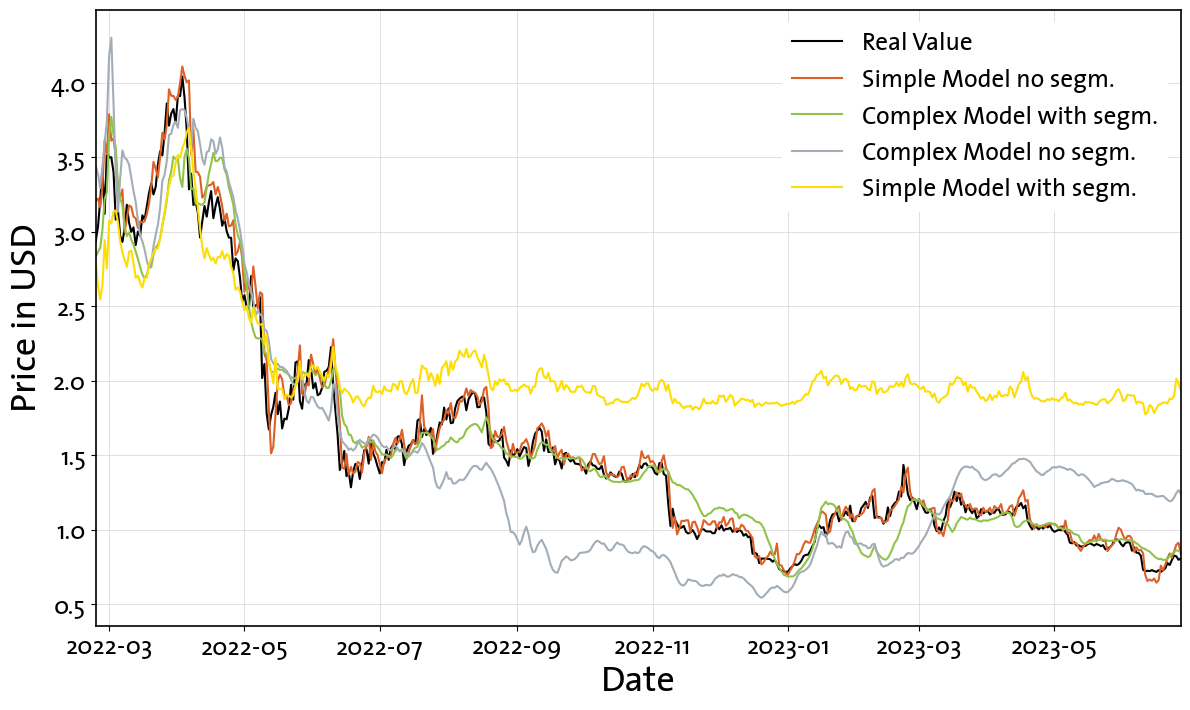

In [79]:
file_name = tezos_figures_dir + "Tezos_all_models_compared.png"

plot_df_simple_with = convert_predictions_df_to_plot_data_df(best_with_segment, data_names_tezos, dates_tezos, y_test_tezos)
plot_df_simple_no = convert_predictions_df_to_plot_data_df(best_no_segment, data_names_tezos, dates_tezos, y_test_tezos)
plot_data_complex_with = convert_predictions_df_to_plot_data_df(best_complex_with_segment, data_names_tezos, dates_tezos, y_test_tezos)
plot_data_complex_no = convert_predictions_df_to_plot_data_df(complex_df_no_segment, data_names_tezos, dates_tezos, y_test_tezos)


plot_df_simple_with.loc[1, "label"] = "Simple Model with segm."
plot_df_simple_no.loc[1, "label"] = "Simple Model no segm."

plot_data_complex_with.loc[1, "label"] = "Complex Model no segm."
plot_data_complex_no.loc[1, "label"] = "Complex Model with segm."

colors = [uzh_colors["green"], uzh_colors["grey"], uzh_colors["yellow"]]
plot_final = plot_df_simple_no
for i, df in enumerate([ plot_data_complex_no, plot_data_complex_with, plot_df_simple_with]):
    df["color"] = colors[i]
    plot_final = pd.concat([plot_final, df.iloc[[1]]], axis = 0)


fig, ax = plt.subplots(1, 1, figsize = (14, 8))
plot_data_simple(ax, plot_final)
plt.savefig(file_name, bbox_inches = "tight")

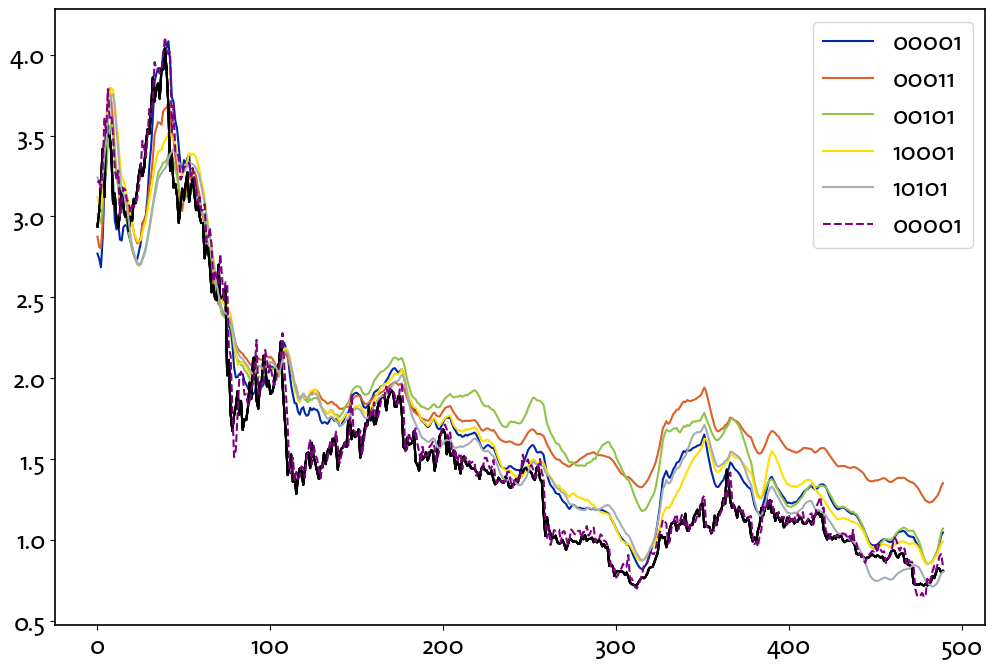

In [5]:
predictions = np.load(tezos_predictions_dir + list(file_dict.keys())[2], allow_pickle=True)
pred = pd.DataFrame(predictions)

predictions2 = np.load(tezos_predictions_dir + list(file_dict.keys())[0], allow_pickle=True)
pred2 = pd.DataFrame(predictions2)

nums = [1, 17, 21, 5, 3]

plt.figure(figsize = (12, 8))
for i, row in pred.iterrows():
    if row[0] not in nums: continue
    yp = pred.loc[i, 6]
    y_tgt = y_test_tezos[-len(yp):]
    plt.plot(range(len(y_tgt)), y_tgt, color="black")

    plt.plot(range(len(yp)), yp,  label="".join([str(j) for j in row[1:6]]))

yp = pred2.loc[0, 6]
plt.plot(range(len(yp)), yp, color = "purple", linestyle = "--", label="".join([str(j) for j in pred2.loc[0, 1:5]]))
plt.legend() 
plt.show()

# ["market", "network", "social", "supply", "TI"]

Text(0.5, 1.0, 'Market Data')

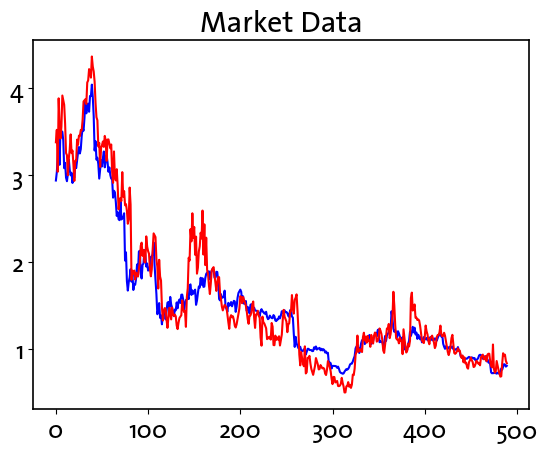

In [16]:
predictions = np.load(tezos_predictions_dir + list(file_dict.keys())[0], allow_pickle=True)
pred = pd.DataFrame(predictions)

yp = pred.loc[8, 6]
y_tgt = y_test_tezos[-len(yp):]
plt.plot(range(len(y_tgt)), y_tgt, color="blue", label ="Target")
plt.plot(range(len(yp)), yp, color="red", label = "Predicted")
plt.title("Market Data")